In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
import mrcnn.model as modellib
import numpy as np
import time

from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.image import img_to_array
from mrcnn import coco
from mrcnn import utils
from mrcnn import visualize

%matplotlib inline

/anaconda3/envs/newest/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Override the default config settings

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

### Create Instance Segmentation Model and Load Trained Weights
#### mask_rcnn_coco.h5 is not saved on my GitHub due to the large file size restriction. You can download it [here](https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5). After downloading it, move the file to the same folder as this Jupyter Notebook.

In [3]:
# Create model object in inference mode.
seg_model = modellib.MaskRCNN(mode='inference', model_dir='', config=config)

# Load weights trained on MS-COCO
seg_model.load_weights('mask_rcnn_coco.h5', by_name=True)

### Create pretrained InceptionV3 model. Used for detecting sunglasses.
#### The instance segmentation model is not capable of detecting sunglasses since it was trained on the COCO dataset. This InceptionV3 model was trained on the ImageNet dataset, which contains sunglasses as one of the classes.

In [4]:
sunglasses_model = InceptionV3(weights='imagenet')

In [5]:
def person_has_sunglasses(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img_rgb, (299, 299))
    img_resized = img_to_array(img_resized)
    img_resized = np.expand_dims(img_resized, axis=0)
    img_resized = preprocess_input(img_resized)

    preds = sunglasses_model.predict(img_resized)
    preds_decoded = imagenet_utils.decode_predictions(preds)
    
    has_sunglasses = False
    for imagenetID, label, prob in preds_decoded[0][:2]:
        if label == 'sunglass' or label == 'sunglasses':
            has_sunglasses = True
            break
    
    return has_sunglasses

### Haar Cascades is used to find the bounding box coordinates of a face. 

In [6]:
def get_bbox_of_face(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    cascade_file_path = 'haarcascade_frontalface_default.xml'
    cascade_clf = cv2.CascadeClassifier(cascade_file_path)

    faces = cascade_clf.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=5)

    return faces[0] if len(faces) > 0 else None

### Utilitly functions 
#### Displays an array of images.

In [7]:
def display_images(imgs, titles):
    _, ax = plt.subplots(1, len(imgs), figsize=(20, 10))
    
    for ix, (img, title) in enumerate(zip(imgs, titles)):
        ax[ix].imshow(img)
        ax[ix].set_title(title)
        ax[ix].axis('off')

#### Gets the mask of the person with the sunglasses and subtracts away any objects in front of that person. The mask is expanded by 10 pixels in all four directions to ensure the person is entirely covered.

In [8]:
def get_person_mask(masks, ix_person):
    p_mask = masks[:, :, ix_person]
    
    padding = 10
    p_mask_2 = np.roll(p_mask, padding, axis=0)
    p_mask_3 = np.roll(p_mask, -padding, axis=0)
    p_mask_4 = np.roll(p_mask, padding, axis=1)
    p_mask_5 = np.roll(p_mask, -padding, axis=1)
    p_masks = [p_mask, p_mask_2, p_mask_3, p_mask_4, p_mask_5]
    p_masks_merged = np.logical_or.reduce(p_masks, axis=0)


    other_masks = np.delete(masks, ix_person, axis=2)
    other_masks_merged = np.logical_or.reduce(other_masks, axis=2)
    
    person_mask_minus_others = p_masks_merged & np.logical_not(other_masks_merged)
    
    return person_mask_minus_others

### Class Names

In [9]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Main function to execute the invisibility code

In [19]:
def run_invisibility_on_image(img, img_background, display_imgs=False):
    """
    Args:
        img (numpy.array): RGB image. Contains people. Used as "read-only" and will not be modified by this function.
        img_background (numpy.array): RGB image. There are no people in this image. 
    """
    start = time.time()
    
    # img_copy will be modified with the pixel manipulations and returned by the function
    img_copy = np.copy(img)
    
    results = seg_model.detect([img], verbose=0)
    results = results[0]
    
    if display_imgs:
        visualize.display_instances(img, results['rois'], results['masks'], results['class_ids'], 
                                    class_names, results['scores'])
    
    # shape of the masks are (h, w, object_ix)
    n_objects_found = len(results['class_ids'])
    for ix in range(n_objects_found):
        if results['class_ids'][ix] == class_names.index('person'):
            bbox = get_bbox_of_face(img)
            if bbox is not None:
                x, y, w, h = bbox
                img_face = img[y : y+h, x : x+w]
                if person_has_sunglasses(img_face):
                    p_mask = results['masks'][:, :, ix]
                    
                    padding = 10
                    p_mask_2 = np.roll(p_mask, padding, axis=0)
                    p_mask_3 = np.roll(p_mask, -padding, axis=0)
                    p_mask_4 = np.roll(p_mask, padding, axis=1)
                    p_mask_5 = np.roll(p_mask, -padding, axis=1)
                    p_masks = [p_mask, p_mask_2, p_mask_3, p_mask_4, p_mask_5]
                    p_masks_merged = np.logical_or.reduce(p_masks, axis=0)

                    other_masks = np.delete(masks, ix, axis=2)
                    other_masks_merged = np.logical_or.reduce(other_masks, axis=2)

                    person_mask_minus_others = p_masks_merged & np.logical_not(other_masks_merged)
                    
                    img_copy[person_mask_minus_others] = img_background[person_mask_minus_others]
                    
                    if display_imgs:
                        # These images will show the effect from each type of mask.
                        img_person_mask = np.copy(img)
                        img_person_mask[p_masks_merged] = [0, 255, 0]

                        img_other_masks_merged = np.copy(img)
                        img_other_masks_merged[other_masks_merged] = [0, 255, 0]
                        
                        imgs_to_display = [img_background, img, img_person_mask, img_other_masks_merged, img_copy]
                        titles = ['Background', 'Original', 'Person Mask', 'Other Masks', 'Final']
                        display_images(imgs_to_display, titles)
    
    end = time.time()
    print('{} seconds to process image'.format(int(end - start)))
    
    return img_copy

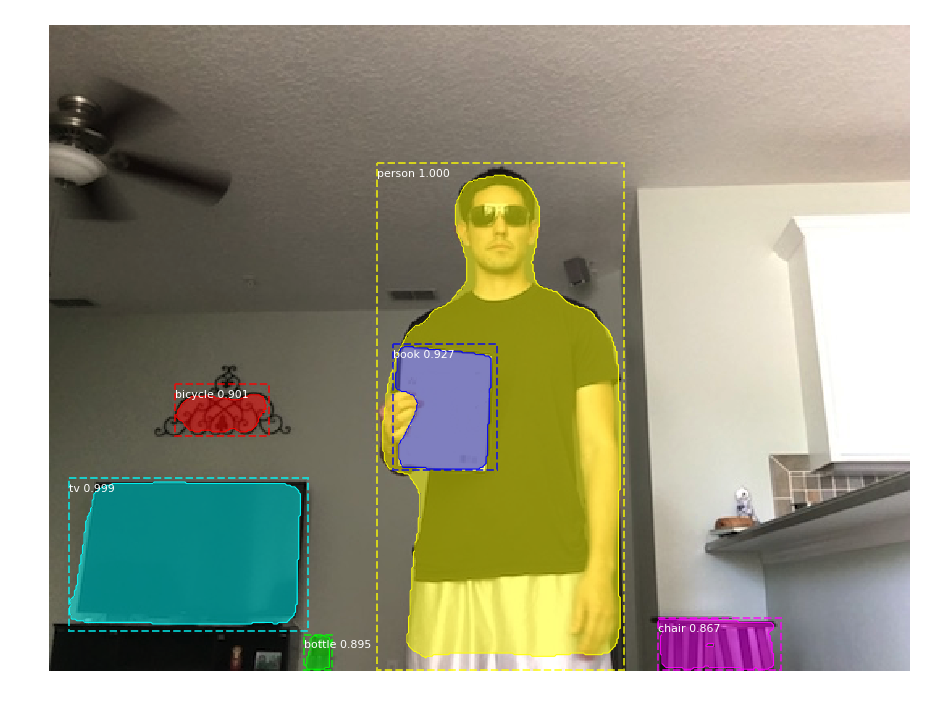

NameError: name 'masks' is not defined

In [20]:
img = cv2.imread('images/glasses_book.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_background = cv2.imread('images/background.jpg')
img_background = cv2.cvtColor(img_background, cv2.COLOR_BGR2RGB)

img_processed = run_invisibility_on_image(img, img_background, display_imgs=True)